In [1]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

# prevent BLAS/LAPACK from using multiple threads per process
#os.environ["OMP_NUM_THREADS"] = "1"
#os.environ["OPENBLAS_NUM_THREADS"] = "1"
#os.environ["MKL_NUM_THREADS"] = "1"
#os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

from utils import timeit, get_allowed_time_intervals, block_flatten

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [2]:
# possibly extent to more activities

LX = 256
base_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LX}'
d_cluster = dict(path = base_path + '_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = LX, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]


## Choose which dataset to visualize
act = 0.028 #22 
num_exp = 0

folder_path = os.path.join(base_path, f'analysis_zeta_{act}',  f'zeta_{act}_counter_{num_exp}')
defect_path = os.path.join(folder_path, 'defect_positions.pkl')

with open(defect_path, 'rb') as f:
    top_defects = pkl.load(f)


In [3]:
dtype = np.uint8
cid_mode = 'lz77'
verbose = True

compression_factor = 2
coarse_graining_box_length = 4
overlap = 0
nshuffle = 8
nbits = 7

njumps_between_frames = 1
top_defects = top_defects[::njumps_between_frames]

num_frames = len(top_defects)
nframes_to_analyze = min(150, num_frames)

observation_window_bounds = [(0, int(LX / compression_factor)), (0, int(LX / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]
lx_window_cg = lx_window // coarse_graining_box_length
ly_window_cg = ly_window // coarse_graining_box_length

nbits_frame = int(np.log2(lx_window_cg))
nframes_per_cube = get_allowed_time_intervals(system_size = lx_window_cg, nbits_max=nbits)[-1]['time_interval']
time_subinterval = nframes_per_cube - overlap
ncubes = 1 + int(((nframes_to_analyze - nframes_per_cube) / time_subinterval))
first_frame_idx = (num_frames - nframes_to_analyze) + (nframes_to_analyze - nframes_per_cube - ((ncubes - 1) * time_subinterval))


defect_grid = np.zeros((num_frames - first_frame_idx, lx_window_cg, ly_window_cg), dtype=dtype)
defect_count_full = []
defect_count = []

print(f"Using window size {lx_window}x{ly_window}.")
print(f"nf_cube,lx_cg,ly_cg= {nframes_per_cube}x{lx_window_cg}x{ly_window_cg}")
print(f"Hypercube shape: {1 << nbits}x{1 << nbits}x{1 << nbits}")
print(f"ncubes: {ncubes}")

for i, defect in enumerate(top_defects[first_frame_idx:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)

    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_count_full.append(len(def_arr))

    local_x = def_arr[:, 0] - observation_window_bounds[0][0]
    local_y = def_arr[:, 1] - observation_window_bounds[1][0]

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (local_x // coarse_graining_box_length).astype(int)
    coarse_y = (local_y // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print(f"Average number of defects in window before/after coarse graining: {np.mean(defect_count_full):.2f}, {np.mean(defect_count):.2f}")
#print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

Using window size 128x128.
nf_cube,lx_cg,ly_cg= 2048x32x32
Hypercube shape: 128x128x128
ncubes: 1
Average number of defects in window before/after coarse graining: 36.89, 36.41


In [ ]:
nbits=2
dim=2
size=1<<nbits
x=np.linspace(1, size**2 , size**2).reshape(-1,size)
x=np.repeat(x[None,:,:,], size, axis=0)
x += np.array([0,100,200,300])[:,None,None]
x=x.astype(np.uint8)
data = np.transpose(x[0]).reshape((-1, ) + (1<<nbits, ) * dim).T
data.squeeze()

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]], dtype=uint8)

In [ ]:
nbits=3
size=1<<nbits
dim=3
L, Nt = 16,2
L, Nt = 8,8
multiplier = 100 if L==8 else 1000

x=np.linspace(1, L**2 , L**2).reshape(-1,L)
x=np.repeat(x[None,:,:,], Nt, axis=0)
x += np.arange(0, multiplier * Nt, multiplier)[:,None,None]
x = x.astype(np.uint16)
x[0][:16,:13], x.shape
data = np.transpose(x[0]).reshape((-1, ) + (1<<nbits, ) * dim).T
data[0,:,:].squeeze()

In [15]:
for order in itter_hscan(data, dim=2,nbits=nbits_frame):
    print(order.shape)

(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)


In [20]:

use_class = True
verbose=False
CID2d = cid2d(nbits=nbits_frame, nshuff=nshuffle,mode=cid_mode, verbose=verbose)
nframes_seq = 10
cid_seq = np.nan*np.ones((nframes_seq, 2))
cid_seq_shuffle = np.nan*np.ones_like(cid_seq)
cid_seq_frac = np.nan*np.ones_like(cid_seq)

t0 = time.perf_counter()
for j in range(nframes_seq):
    print(f"Calculating CID for frame {j+1}/{nframes_seq}...", end=' ')
    ff_idx = j
    data = defect_grid[ff_idx,:,:]

    if use_class:
        cid_av, cid_std, cid_shuff = CID2d(data)
    else:
        t1 = time.perf_counter()
        cid_temp = []
        for order in itter_hscan(data, dim=2,nbits=nbits_frame):
            cid_temp.append(cid(order))
        print(cid_temp)
        if verbose: print(f"CID took {time.perf_counter()-t1:.2f} s")
 
        cid_av = np.mean(cid_temp)
        cid_std = np.std(cid_temp)
        t2= time.perf_counter()
        cid_shuff = cid_shuffle(data.ravel(), nshuff=16, cid_mode=cid_mode)
        if verbose: print(f"CID shuffle took {time.perf_counter()-t2:.2f} s")

    cid_seq[j, 0] = cid_av
    cid_seq[j, 1] = cid_std
    cid_seq_shuffle[j, :] = cid_shuff

cid_seq_frac[:, 0] = cid_seq[:, 0] / cid_seq_shuffle[:, 0]
cid_seq_frac[:, 1] = cid_seq_frac[:, 0] * np.sqrt( (cid_seq[:, 1]/cid_seq[:, 0])**2 + (cid_seq_shuffle[:, 1]/cid_seq_shuffle[:, 0])**2 )

print(f"cid mean: {np.nanmean(cid_seq[:,0]):.3f} +/- {np.nanstd(cid_seq[:,0]):.3f}")
print(f"cid shuffle mean: {np.nanmean(cid_seq_shuffle[:,0]):.3f} +/- {np.nanstd(cid_seq_shuffle[:,0]):.3f}")
# 
print(f"Done. Total time: {time.perf_counter()-t0:.2f} s")

Calculating CID for frame 1/10... Calculating CID for frame 2/10... Calculating CID for frame 3/10... Calculating CID for frame 4/10... Calculating CID for frame 5/10... Calculating CID for frame 6/10... Calculating CID for frame 7/10... Calculating CID for frame 8/10... Calculating CID for frame 9/10... Calculating CID for frame 10/10... cid mean: 0.358 +/- 0.013
cid shuffle mean: 0.365 +/- 0.013
Done. Total time: 16.86 s


In [23]:
nshuffle

8

In [24]:
CID2d = cid2d(nbits=nbits_frame, nshuff=nshuffle,mode=cid_mode, verbose=False)

nframes_seq = 2
cid_seq = np.nan*np.ones((nframes_seq, 2))
cid_seq_shuffle = np.nan*np.ones_like(cid_seq)
cid_seq_frac = np.nan*np.ones_like(cid_seq)

for j in range(nframes_seq):
    print(f"Calculating CID for frame {j+1}/{nframes_seq}...", end=' ')
    ff_idx = j
    data = defect_grid[ff_idx,:,:]

    cid_temp = []
    for order in itter_hscan(data, dim=2,nbits=nbits_frame):
        cid_temp.append(cid(data.ravel(),))

   # cid_av, cid_std, cid_shuff = CID2d(data)
    cid_seq[j, 0] = cid_av
    cid_seq[j, 1] = cid_std
    cid_seq_shuffle[j, :] = cid_shuff

cid_seq_frac[:, 0] = cid_seq[:, 0] / cid_seq_shuffle[:, 0]
cid_seq_frac[:, 1] = cid_seq_frac[:, 0] * np.sqrt( (cid_seq[:, 1]/cid_seq[:, 0])**2 + (cid_seq_shuffle[:, 1]/cid_seq_shuffle[:, 0])**2 )

Calculating CID for frame 1/2... Calculating CID for frame 2/2... 

In [25]:
cid_seq_shuffle[:,1]

array([0.00632048, 0.00632048])

In [248]:
t3 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle,mode=cid_mode, verbose=False)
cid_arr = np.nan * np.ones((ncubes, 2))
cid_shuffle_arr = np.nan * np.ones_like(cid_arr)
cid_frac_arr = np.nan * np.ones_like(cid_arr)

for j in range(ncubes):
    print(f"Calculating CID for cube {j+1}/{ncubes}...", end=' ')
    data = defect_grid[j * time_subinterval:(j+1)*time_subinterval+overlap]

    cid_av, cid_std, cid_shuff = CID(data)
    cid_arr[j, 0] = cid_av
    cid_arr[j, 1] = cid_std
    cid_shuffle_arr[j, :] = cid_shuff

cid_frac_arr[:, 0] = cid_arr[:, 0] / cid_shuffle_arr[:, 0]
cid_frac_arr[:, 1] = cid_frac_arr[:, 0] * np.sqrt( (cid_arr[:, 1]/cid_arr[:, 0])**2 + (cid_shuffle_arr[:, 1]/cid_shuffle_arr[:, 0])**2 )

Calculating CID for cube 1/37... Calculating CID for cube 2/37... Calculating CID for cube 3/37... Calculating CID for cube 4/37... Calculating CID for cube 5/37... Calculating CID for cube 6/37... Calculating CID for cube 7/37... Calculating CID for cube 8/37... Calculating CID for cube 9/37... Calculating CID for cube 10/37... Calculating CID for cube 11/37... Calculating CID for cube 12/37... Calculating CID for cube 13/37... Calculating CID for cube 14/37... Calculating CID for cube 15/37... Calculating CID for cube 16/37... Calculating CID for cube 17/37... Calculating CID for cube 18/37... Calculating CID for cube 19/37... Calculating CID for cube 20/37... Calculating CID for cube 21/37... Calculating CID for cube 22/37... Calculating CID for cube 23/37... Calculating CID for cube 24/37... Calculating CID for cube 25/37... Calculating CID for cube 26/37... Calculating CID for cube 27/37... Calculating CID for cube 28/37... Calculating CID for cube 29/37... Calculating CID for cub

Mean CID: 0.980 +/- 0.018


Text(0.5, 1.0, 'n=7, cf=2, box=4')

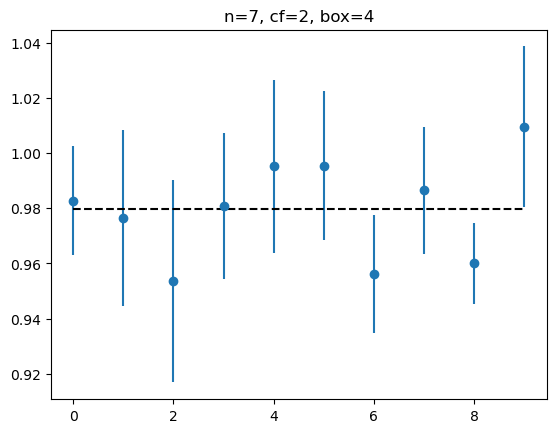

In [22]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(nframes_seq), cid_seq_frac[:,0], yerr=cid_seq_frac[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_seq_frac[:,0]), 0, nframes_seq-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_seq_frac[:,0]):.3f} +/- {np.nanstd(cid_seq_frac[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

Mean CID: 0.988 +/- 0.020


Text(0.5, 1.0, 'n=7, cf=2, box=4')

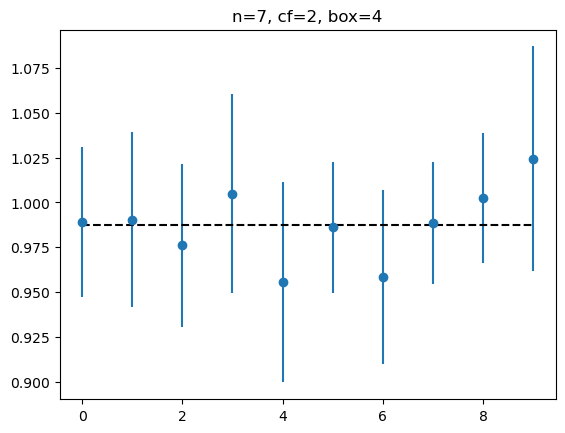

In [18]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(nframes_seq), cid_seq_frac[:,0], yerr=cid_seq_frac[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_seq_frac[:,0]), 0, nframes_seq-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_seq_frac[:,0]):.3f} +/- {np.nanstd(cid_seq_frac[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

Mean CID: 0.983 +/- 0.055


Text(0.5, 1.0, 'n=2, cf=4, box=2')

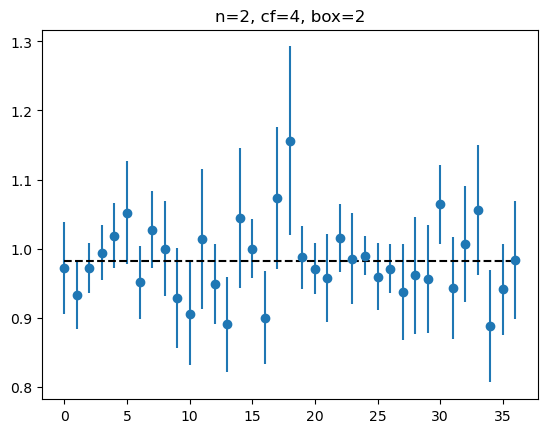

In [328]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_frac_arr[:,0]):.3f} +/- {np.nanstd(cid_frac_arr[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

Mean CID: 0.941 +/- 0.003


Text(0.5, 1.0, 'n=5, cf=4, box=2')

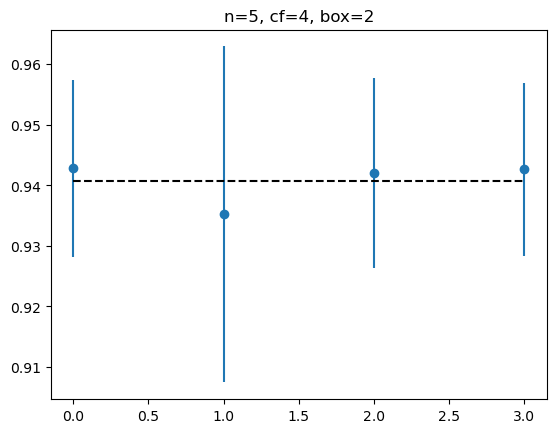

In [246]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_frac_arr[:,0]):.3f} +/- {np.nanstd(cid_frac_arr[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

Mean CID: 0.947 +/- 0.011


Text(0.5, 1.0, 'n=5, cf=2, box=4')

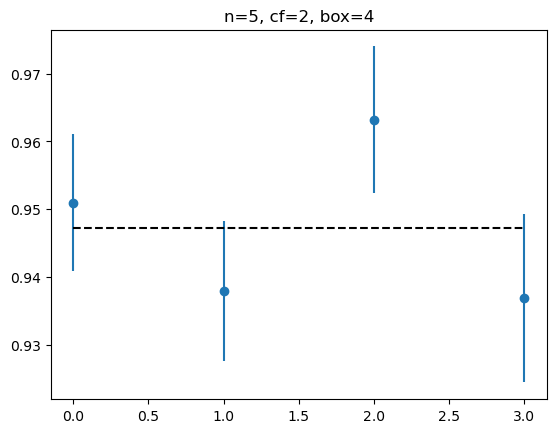

In [242]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_frac_arr[:,0]):.3f} +/- {np.nanstd(cid_frac_arr[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

Mean CID: 0.996 +/- 0.007


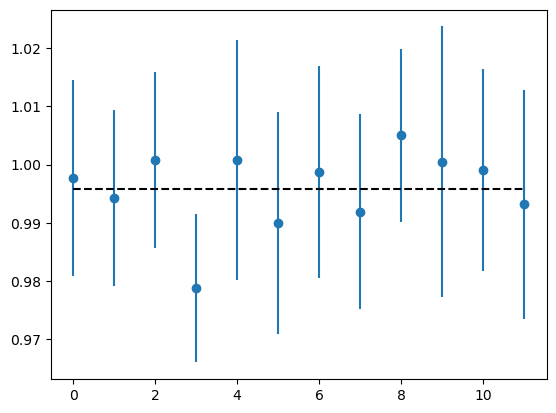

In [46]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_frac_arr[:,0]):.3f} +/- {np.nanstd(cid_frac_arr[:,0]):.3f}")

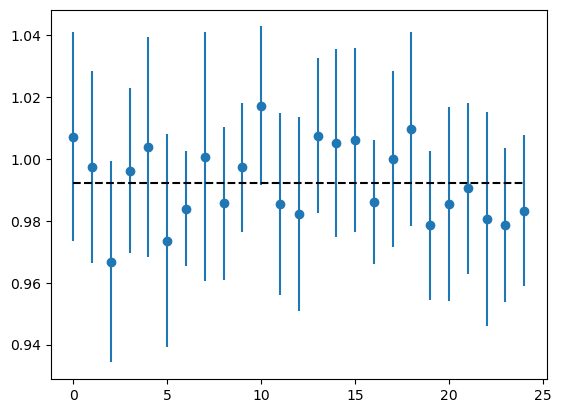

In [40]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')

In [ ]:
## thinks:
# dynamic coarse graining box size based on defect density?
# allowing for dynamic nframes to get hypercube slices in time?

compression_factor = 2
coarse_graining_box_length = 4
nframes, nx, ny = 32, d_cluster_l['LX'], d_cluster_l['LX']

observation_window_bounds = [(0, int(nx / compression_factor)), (0, int(ny / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]

lx_window_cg = lx_window // coarse_graining_box_length
ly_window_cg = ly_window // coarse_graining_box_length




defect_grid = np.zeros((nframes, lx_window_cg, ly_window_cg), dtype=int)
defect_count_full = []
defect_count = []

print(f"Using window size {lx_window}x{ly_window}.")
print(f"Defect grid shape with coarse graining box length {coarse_graining_box_length}: {defect_grid.shape}")

nbits_frame = int(np.log2(lx_window_cg))

if not lx_window_cg == ly_window_cg:
    raise ValueError("Cg observation windows must be square.")

allowed_intervals_list = get_allowed_time_intervals(system_size = lx_window_cg  , nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

print(f"Using nbits = {nbits} (size {1 << nbits}) for nframes = {nframes} and cg window size {lx_window_cg}x{ly_window_cg}")

for i, defect in enumerate(defect_list[-nframes:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)
   # print(len(def_arr   ))
    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_count_full.append(len(def_arr))

    local_x = def_arr[:, 0] - observation_window_bounds[0][0]
    local_y = def_arr[:, 1] - observation_window_bounds[1][0]

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (local_x // coarse_graining_box_length).astype(int)
    coarse_y = (local_y // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print("Average number of defects in window before/after coarse graining: ", np.mean(defect_count_full), np.mean(defect_count))
print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

In [102]:
do_hscan = True
nshuff=4
time_subinterval = 8
nbits_subinterval = int(np.log2(time_subinterval * lx_window_cg * ly_window_cg) / 3)
nframes_max = nframes

nsub_frames = min(nframes_max, nframes) // time_subinterval
implementation_list =[lz77py_dev, lz77_complexity,lz77_complexity_linear]# lz77py_dev, lz77_complexity_linear]#, lz77_complexity, compression_wrapper(lz77_complexity_comp,  kwargs={'window_size': 512})] #, lz77_complexity_comp, lz77_complexity_suffix_automaton, lz77_complexity_linear]

cid_arr_sp = np.nan * np.zeros((len(implementation_list), nsub_frames, 4))
dt_arr_sp = np.nan * np.zeros((len(implementation_list), nsub_frames))
div_arr = np.nan * np.zeros((len(implementation_list), nsub_frames, 2))
div_arr_av = np.nan * np.zeros((len(implementation_list), 2))

for i, implementation in enumerate(implementation_list):
    print(f"Calculating CID using {implementation.__name__}")
    t1 = time.perf_counter()
    for j in range(nsub_frames):
        ## print if run is 10%, 20%, ..., 90% complete
        if j % (nsub_frames // 10) == 0:
            print(f" Subinterval {j+1}/{nsub_frames}...", end='', flush=True)
        data = defect_grid[j * time_subinterval:(j+1)*time_subinterval].ravel()
        data_ordered = list(itter_hscan(data, dim=3 if nframes>1 else 2, nbits=nbits_subinterval))
        cid_vals_temp =  []
        for k, row in enumerate(data_ordered):
            cid_vals_temp.append(cid_deve(row, implementation=implementation, verbose=0))

        cid_arr_sp[i, j, 0] = np.mean(cid_vals_temp)
        cid_arr_sp[i, j, 1] = (np.std(cid_vals_temp) / np.sqrt(len(cid_vals_temp))) if len(cid_vals_temp) > 1 else 0

        cid_shuff_vals = cid_shuffle_deve_unp(data, nshuff=nshuff, cid_func=cid_deve, ddof=1, cid_kwargs={"implementation": implementation, 'verbose': 0})
        cid_arr_sp[i, j, 2:] = cid_shuff_vals
        cid_arr_sp[i, j, 3] /= np.sqrt(nshuff) # std error of the mean
        dt_arr_sp[i, j] = time.perf_counter() - t1
        #print(f"Done. Time elapsed: {dt_arr_sp[i, j]:.3f} s")

div_arr[:,:,0] = cid_arr_sp[:,:,0] / cid_arr_sp[:,:,2]
div_arr[:,:,1] = np.sqrt(cid_arr_sp[:,:,1]**2 + (cid_arr_sp[:,:,0] * cid_arr_sp[:,:,3] / cid_arr_sp[:,:,2])**2) / cid_arr_sp[:,:,2]

div_av, div_sem = calc_weighted_mean(x=div_arr[:, :, 0], dx=div_arr[:, :, 1], axis=1)
div_arr_av[:,0] = div_av
div_arr_av[:,1] = div_sem


Calculating CID using lz77py_dev
 Subinterval 1/32... Subinterval 4/32... Subinterval 7/32... Subinterval 10/32... Subinterval 13/32... Subinterval 16/32... Subinterval 19/32... Subinterval 22/32... Subinterval 25/32... Subinterval 28/32... Subinterval 31/32...Calculating CID using lz77_complexity
 Subinterval 1/32... Subinterval 4/32... Subinterval 7/32... Subinterval 10/32... Subinterval 13/32... Subinterval 16/32... Subinterval 19/32... Subinterval 22/32... Subinterval 25/32... Subinterval 28/32... Subinterval 31/32...Calculating CID using lz77_complexity_linear
 Subinterval 1/32... Subinterval 4/32... Subinterval 7/32... Subinterval 10/32... Subinterval 13/32... Subinterval 16/32... Subinterval 19/32... Subinterval 22/32... Subinterval 25/32... Subinterval 28/32... Subinterval 31/32...

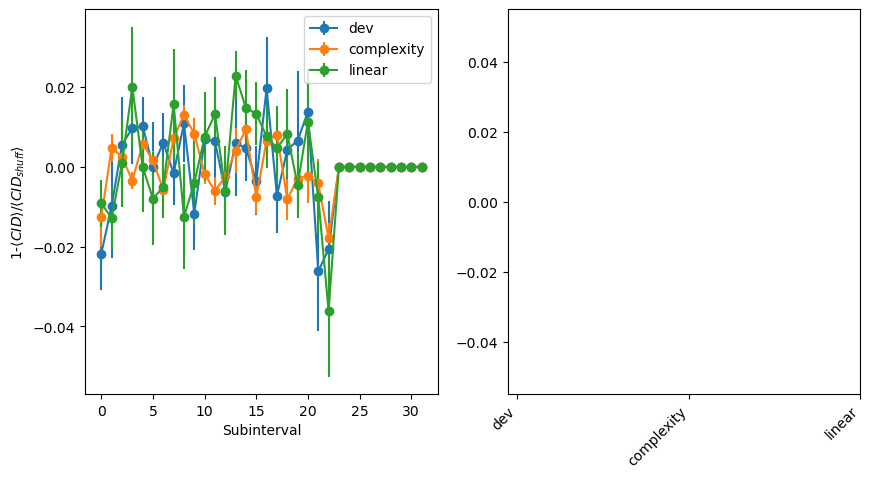

In [104]:
plot_div=True
fig, ax = plt.subplots(1,2, figsize=(10,5))
for i, implementation in enumerate(implementation_list):
    div_av, div_std = div_arr_av[i]

    label = implementation.__name__.split('_')[-1]

    y=1-div_arr[i,:,0] if plot_div else div_arr[i,:,0]
    ax[0].errorbar(x=np.arange(nsub_frames), y=y, yerr=div_arr[i,:,1], fmt='o-', label=label)

    ax[1].bar(i, 1-div_av, yerr=div_std, capsize=5, label=label)
  #  ax[1].bar(i, dt_arr_sp[i], label=implementation.__name__)

ax[0].legend()
ax[0].set_xlabel("Subinterval")
ylabel_prefix = r"1-" if plot_div else r"" 
ax[0].set_ylabel(ylabel_prefix + r"$\langle CID \rangle / \langle CID_{shuff} \rangle$")

ax[1].set_xticks(range(len(implementation_list)), [impl.__name__.split('_')[-1] for impl in implementation_list], rotation=45, ha='right')
